# Testing notebook

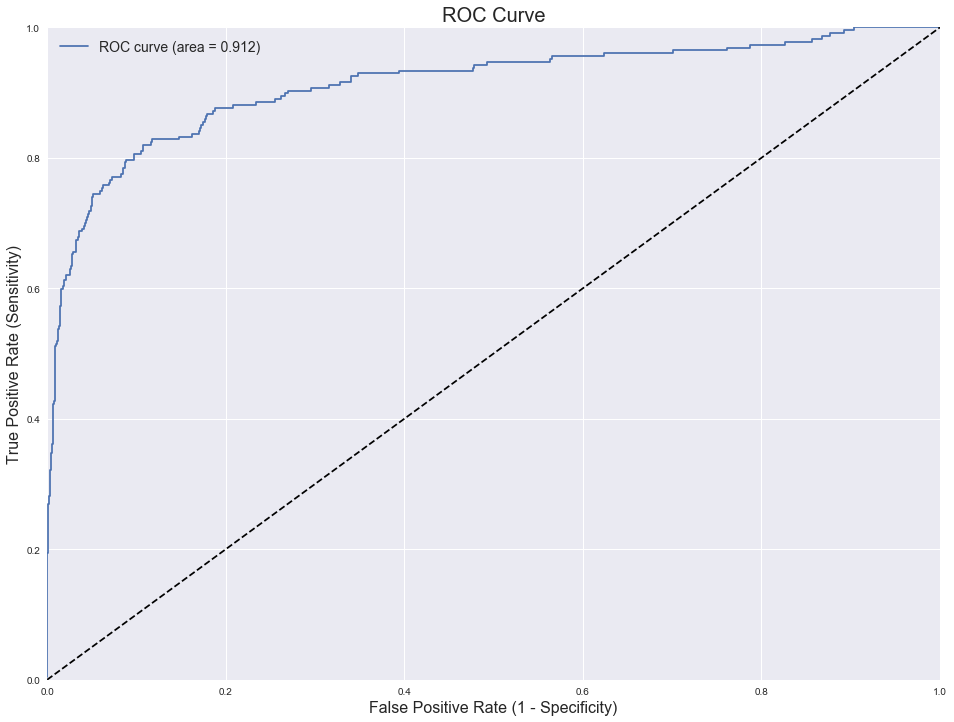

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC

import numpy as np
import pandas as pd

from pmlb import fetch_data

import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

sns.set(rc={"figure.figsize": (12, 8)})


class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])



df = pmlb.fetch_data('churn', return_X_y=False)

# Remove the target column and the phone number
x_cols = [c for c in df if c not in ["target", "phone number"]]

binary_features = ["international plan", "voice mail plan"]
categorical_features = ["state", "area code"]

# Column types are defaulted to floats
X = (
    df
    .drop(["target"], axis=1)
    .astype(float)
)
X[binary_features] = X[binary_features].astype("bool")

# Categorical features can't be set all at once
for f in categorical_features:
    X[f] = X[f].astype("category")

y = df.target

# Randomly set 500 items as missing values
random.seed(42)
num_missing = 500
indices = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
for row, col in random.sample(indices, num_missing):
    X.iat[row, col] = np.nan

# Partition data set into training/test split (2 to 1 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3., random_state=42)


preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            Imputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            Imputer(strategy="most_frequent"),
            OneHotEncoder()
        )),
        ("boolean_features", make_pipeline(
            TypeSelector("bool"),
            Imputer(strategy="most_frequent")
        ))
    ])
)

classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    SVC(kernel="rbf", random_state=42)
)

param_grid = {
    "svc__gamma": [0.1 * x for x in range(1, 6)]
}

classifier_model = GridSearchCV(classifier_pipeline, param_grid, cv=10)
classifier_model.fit(X_train, y_train)

y_score = classifier_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14)